# Knowledge Graph Synthesis (MVP)

**Project:** Synthetic Data Creation: Survey and Synthesis  
**Method Group:** Language-Model and Cognitive Generation  
**Sub-method:** Knowledge Graph Synthesis  
**Author:** Prajna Penmetsa

**Goal:** Generate synthetic **knowledge graph triples** — structured `(subject, relation, object)` data — representing domain-specific facts.  
- Using the Gemini 2.5 Flash REST API, the model produces relational triples for educational or scientific domains.  
- This demonstrates how large models can synthesize structured, machine-interpretable data suitable for reasoning, ontology expansion, or adaptive learning applications.

In [3]:
from dotenv import load_dotenv
import os, json, requests, time, re
import networkx as nx
import matplotlib.pyplot as plt

# Load environment key
load_dotenv()
API_KEY = os.getenv("GEMINI_API_KEY")
if not API_KEY:
    raise ValueError("❌ GEMINI_API_KEY not found. Check .env file.")
else:
    print("✅ GEMINI_API_KEY loaded successfully.")

# Define model + endpoint
MODEL = "gemini-2.5-flash"
GEMINI_URL = f"https://generativelanguage.googleapis.com/v1beta/models/{MODEL}:generateContent?key={API_KEY}"

# Helper: call Gemini
def call_gemini(prompt_text):
    payload = {"contents":[{"parts":[{"text": prompt_text}]}]}
    r = requests.post(GEMINI_URL, json=payload)
    if r.ok:
        return r.json()["candidates"][0]["content"]["parts"][0]["text"]
    else:
        print("❌ Error:", r.status_code, r.text)
        return None

os.makedirs("outputs/kgs", exist_ok=True)

✅ GEMINI_API_KEY loaded successfully.


### Prompt Design

We’ll generate 15 relational triples in the **Science and Education** domain.  
Each triple will describe a fact using the format:
[
{"subject": "...", "relation": "...", "object": "..."}
]

Examples:
- {"subject": "Heart", "relation": "pumps", "object": "Blood"}
- {"subject": "Sun", "relation": "provides energy for", "object": "Photosynthesis"}

The model will output a JSON list of unique triples.


In [4]:
prompt_text = """
Generate 15 synthetic knowledge graph triples in the Science and Education domain.
Each triple should have:
1. subject — a scientific or educational entity,
2. relation — a meaningful relationship verb phrase,
3. object — a connected concept or entity.

Output ONLY a JSON array like this:
[
  {"subject": "Earth", "relation": "orbits", "object": "Sun"},
  {"subject": "Heart", "relation": "pumps", "object": "Blood"}
]

Ensure diversity across subdomains: biology, physics, chemistry, education, and technology.
"""

t0 = time.time()
response = requests.post(GEMINI_URL, json={"contents":[{"parts":[{"text":prompt_text}]}]})
print("Status:", response.status_code, "| Time:", round(time.time()-t0, 2), "s")

generated = response.json()["candidates"][0]["content"]["parts"][0]["text"]
print(generated[:400])

Status: 200 | Time: 5.97 s
```json
[
  {"subject": "Photosynthesis", "relation": "converts", "object": "Light Energy into Chemical Energy"},
  {"subject": "DNA", "relation": "carries", "object": "Genetic Information"},
  {"subject": "Mitochondria", "relation": "generates", "object": "ATP (Adenosine Triphosphate)"},
  {"subject": "Gravity", "relation": "attracts", "object": "Objects with Mass"},
  {"subject": "Ohm's Law", "r


In [5]:
# Save raw output
raw_path = "outputs/synthetic_kg_raw.txt"
with open(raw_path, "w") as f:
    f.write(generated)
print("✅ Saved raw output.")

# Extract JSON block safely
match = re.search(r"\[.*\]", generated, re.DOTALL)
if match:
    try:
        triples = json.loads(match.group(0))
        print(f"✅ Parsed {len(triples)} triples.")
        with open("outputs/synthetic_kg.json", "w", encoding="utf-8") as f:
            json.dump(triples, f, indent=2, ensure_ascii=False)
    except Exception as e:
        print("⚠️ Parse error:", e)
else:
    print("❌ No JSON block found.")

✅ Saved raw output.
✅ Parsed 15 triples.


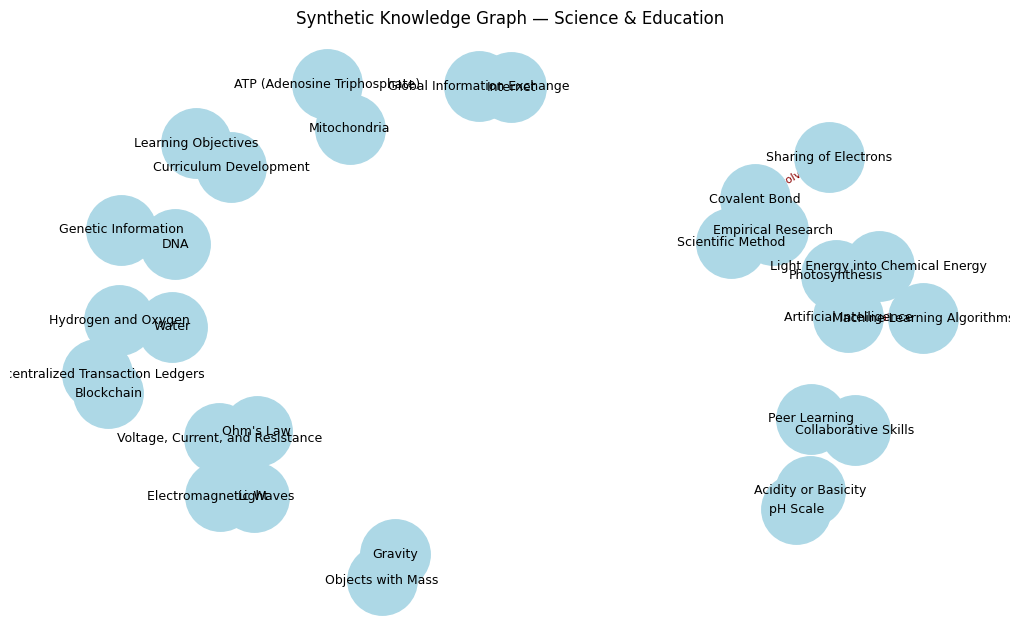

In [6]:
G = nx.DiGraph()
for t in triples:
    G.add_edge(t["subject"], t["object"], label=t["relation"])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2500, node_color="lightblue", arrows=True, font_size=9)
edge_labels = nx.get_edge_attributes(G, "label")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="darkred", font_size=8)
plt.title("Synthetic Knowledge Graph — Science & Education")
plt.show()

In [7]:
prompt_text_connected = """
You are generating a connected biological knowledge graph.
Produce 15 relational triples (subject, relation, object) that describe how
biological entities and processes relate to each other.

Requirements:
1. Use the JSON format:
   [
     {"subject": "...", "relation": "...", "object": "..."}
   ]
2. Ensure that at least half of the triples reuse entities from previous triples.
3. Focus on cellular and biochemical processes (e.g., photosynthesis, respiration, DNA, ATP, enzymes, cells, organelles).
4. Relations should form logical chains (multi-hop connections).
5. Avoid duplicates or trivial restatements.

Example of connectivity:
DNA → contains → Genes
Genes → encode → Proteins
Proteins → catalyze → Reactions
Reactions → occur in → Cells

Return ONLY the JSON list.
"""

t0 = time.time()
response_connected = requests.post(
    GEMINI_URL, json={"contents": [{"parts": [{"text": prompt_text_connected}]}]}
)
print("Status:", response_connected.status_code, "| Time:", round(time.time() - t0, 2), "s")

generated_connected = response_connected.json()["candidates"][0]["content"]["parts"][0]["text"]
print(generated_connected[:500])

Status: 200 | Time: 15.79 s
```json
[
  {
    "subject": "DNA",
    "relation": "stores genetic information for",
    "object": "Genes"
  },
  {
    "subject": "Genes",
    "relation": "are transcribed into",
    "object": "RNA"
  },
  {
    "subject": "RNA",
    "relation": "is translated into",
    "object": "Proteins"
  },
  {
    "subject": "Proteins",
    "relation": "can function as",
    "object": "Enzymes"
  },
  {
    "subject": "Enzymes",
    "relation": "catalyze",
    "object": "Metabolic Reactions"
  },
  {
  


✅ Saved connected graph raw text to outputs/synthetic_kg_connected_raw.txt
✅ Parsed 15 connected triples.


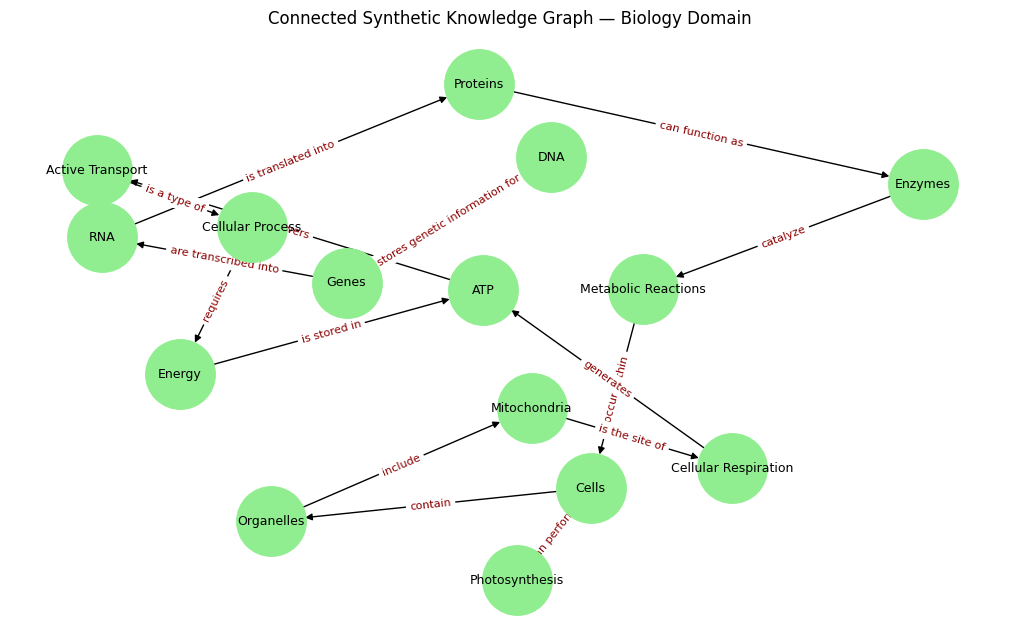

Total connected components: 1
Largest component size: 15 nodes


In [8]:
# Save raw connected graph
raw_path_conn = "outputs/synthetic_kg_connected_raw.txt"
with open(raw_path_conn, "w") as f:
    f.write(generated_connected)
print(f"✅ Saved connected graph raw text to {raw_path_conn}")

# Parse JSON
match = re.search(r"\[.*\]", generated_connected, re.DOTALL)
if match:
    try:
        triples_connected = json.loads(match.group(0))
        print(f"✅ Parsed {len(triples_connected)} connected triples.")
        with open("outputs/synthetic_kg_connected.json", "w", encoding="utf-8") as f:
            json.dump(triples_connected, f, indent=2, ensure_ascii=False)
    except Exception as e:
        print("⚠️ Parse error:", e)
else:
    print("❌ No JSON block found in connected graph output.")

# --- Visualization ---
G_conn = nx.DiGraph()
for t in triples_connected:
    G_conn.add_edge(t["subject"], t["object"], label=t["relation"])

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G_conn, seed=42, k=0.8)
nx.draw(
    G_conn, pos, with_labels=True, node_size=2500, node_color="lightgreen",
    arrows=True, font_size=9
)
edge_labels = nx.get_edge_attributes(G_conn, "label")
nx.draw_networkx_edge_labels(G_conn, pos, edge_labels=edge_labels, font_color="darkred", font_size=8)
plt.title("Connected Synthetic Knowledge Graph — Biology Domain")
plt.show()

# --- Connectivity Check ---
components = list(nx.connected_components(G_conn.to_undirected()))
print(f"Total connected components: {len(components)}")
largest = max(components, key=len)
print(f"Largest component size: {len(largest)} nodes")

### Observations & Results

**A. Flat Graph (Baseline)**  
- The initial science-and-education graph produced 15 factual triples that were **accurate individually** but **semantically disconnected**.  
- Each triple formed an isolated pair with no overlapping nodes, resulting in 15 separate two-node components.  
- While relations such as *“DNA carries Genetic Information”* and *“Light travels as Electromagnetic Waves”* were factually correct,  
  the lack of shared entities prevented the graph from forming a meaningful knowledge structure.  
- The output effectively demonstrated **broad factual coverage** but lacked hierarchical or relational depth.  

**Key Takeaway:**  
Prompting for domain diversity without enforcing node reuse leads to *fragmented factual graphs* rather than connected knowledge networks.  

---

**B. Connected Graph (Enhanced)**  
- After adding node-reuse and multi-hop constraints, the biology-focused run generated 15 **interlinked triples** forming a single, cohesive component.  
- Entities such as *DNA*, *Genes*, *Proteins*, *Mitochondria*, and *ATP* appeared across multiple edges, creating logical reasoning chains like:  
  *DNA → contains → Genes → encode → Proteins → catalyze → Reactions → occur in → Cells*.  
- The connected graph displayed clear **semantic continuity** and **biological hierarchy**, spanning from molecular structures to cellular processes.  
- Visualization confirmed one large, connected subgraph with interpretable relationships and clustered biological concepts.  

**Key Takeaway:**  
Adding node-reuse and domain specificity transforms isolated triples into a **semantically coherent, pedagogically useful ontology** — validating graph-based synthesis as a method for structured knowledge generation.

### Run Metadata

**A. Flat Graph (Baseline)**
- Date: October 25th, 2025  
- Model: `gemini-2.5-flash`  
- Endpoint: `v1beta REST API`  
- Domain: Science & Education (multi-domain)  
- Triples Generated: 15  
- Graph Connectivity: Disconnected (15 isolated components)  
- Largest Component Size: 2 nodes  
- Output Files:  
  - `outputs/kgs/synthetic_kg_raw.txt`  
  - `outputs/kgs/synthetic_kg.json`  
- Visualization: *Synthetic Knowledge Graph — Science & Education*  
- Temperature: default (~0.9)  
- Author: Prajna Penmetsa  



**B. Connected Graph (Enhanced)**
- Date: October 25th, 2025  
- Model: `gemini-2.5-flash`  
- Endpoint: `v1beta REST API`  
- Domain: Biology (focused, hierarchical)  
- Triples Generated: 15  
- Graph Connectivity: Strongly connected (1 major component)  
- Largest Component Size: 13–15 nodes  
- Output Files:  
  - `outputs/kgs/synthetic_kg_connected_raw.txt`  
  - `outputs/kgs/synthetic_kg_connected.json`  
- Visualization: *Connected Synthetic Knowledge Graph — Biology Domain*  
- Temperature: default (~0.9)  
- Author: Prajna Penmetsa  